05.24 RoPE (Rotary Positional Embedding)

In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
#
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

from typing import Tuple

import torch


def rotate_half(x):
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)


def apply_rotary_pos_emb(x, cos, sin):
    # x (query or key vector) : [B, L, dim]
    # cos (cosine table)      : [1, _seq_len_cached, dim]
    # sin (sine table)        : [1, _seq_len_cached, dim]
    cos = cos[:, : x.shape[-2], :]
    sin = sin[:, : x.shape[-2], :]

    return (x * cos) + (rotate_half(x) * sin)


class RotaryEmbedding(torch.nn.Module):
    """
    The rotary position embeddings from RoFormer_ (Su et. al).
    A crucial insight from the method is that the query and keys are
    transformed by rotation matrices which depend on the relative positions.
    Other implementations are available in the Rotary Transformer repo_ and in
    GPT-NeoX_, GPT-NeoX was an inspiration
    .. _RoFormer: https://arxiv.org/abs/2104.09864
    .. _repo: https://github.com/ZhuiyiTechnology/roformer
    .. _GPT-NeoX: https://github.com/EleutherAI/gpt-neox
    .. warning: Please note that this embedding is not registered on purpose, as it is transformative
        (it does not create the embedding dimension) and will likely be picked up (imported) on a ad-hoc basis
    """

    def __init__(self, dim: int, *_, **__):
        super().__init__()
        # Generate and save the inverse frequency buffer (non trainable)
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim)) # theta1, theta2 .... theta dim/2
        self.register_buffer("inv_freq", inv_freq)

        self._seq_len_cached = None
        self._cos_cached = None
        self._sin_cached = None

    def _update_cos_sin_tables(self, x, seq_dimension=1):
        seq_len = x.shape[seq_dimension]

        # Reset the tables if the sequence length has changed,
        # or if we're on a new device (possibly due to tracing for instance)
        if seq_len != self._seq_len_cached or self._cos_cached.device != x.device:
            self._seq_len_cached = seq_len
            t = torch.arange(x.shape[seq_dimension], device=x.device).type_as(self.inv_freq) # seq_len : 1, 2, ... , L (position)
            freqs = torch.einsum("i,j->ij", t, self.inv_freq) # [seq_len, dim/2] : position_m theta_1 , position_m theta_2, ... , position_m theta_dim/2
            emb = torch.cat((freqs, freqs), dim=-1).to(x.device) # cat [seq_len, dim/2] -> [seq_len, dim]

            self._cos_cached = emb.cos()[None, :, :]
            self._sin_cached = emb.sin()[None, :, :]

        return self._cos_cached, self._sin_cached

    def forward(self, q: torch.Tensor, k: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        self._cos_cached, self._sin_cached = self._update_cos_sin_tables(k, seq_dimension=-2)

        return (
            apply_rotary_pos_emb(q, self._cos_cached, self._sin_cached),
            apply_rotary_pos_emb(k, self._cos_cached, self._sin_cached),
        )

In [2]:
batch = 2
length = 5
dim = 8
query = torch.randn((batch,length,dim))
key = torch.randn((batch,length,dim))
rope = RotaryEmbedding(dim)

In [4]:
dim = 1280
inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))

In [14]:
seq_length = 1500
freqs = 10000 ** (torch.arange(0, dim, 2).float() / dim)
t = torch.arange(seq_length).type_as(inv_freq) # seq_len : 1, 2, ... , L (position)
freqs = torch.einsum("i,j->ij", t, inv_freq) # [seq_len, dim/2] : position_m theta_1 , position_m theta_2, ... , position_m theta_dim/2
emb = torch.cat((freqs, freqs), dim=-1)

_cos_cached = emb.cos()[None, :, :]
_sin_cached = emb.sin()[None, :, :]

In [15]:
_sin_cached

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           0.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  8.3367e-01,  8.2580e-01,  ...,  1.0441e-04,
           1.0292e-04,  1.0145e-04],
         [ 9.0930e-01,  9.2082e-01,  9.3144e-01,  ...,  2.0882e-04,
           2.0584e-04,  2.0290e-04],
         ...,
         [ 9.9952e-01, -8.0628e-01,  3.0294e-02,  ...,  1.5567e-01,
           1.5346e-01,  1.5129e-01],
         [ 5.1388e-01,  4.7870e-02, -8.0830e-01,  ...,  1.5577e-01,
           1.5356e-01,  1.5139e-01],
         [-4.4422e-01,  8.5915e-01, -9.4204e-01,  ...,  1.5588e-01,
           1.5367e-01,  1.5149e-01]]])

In [9]:
inv_freq[0]

tensor(1.)

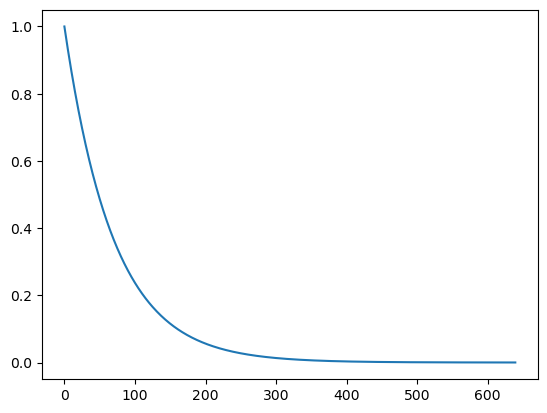

In [8]:
# plot the inverse frequency with torch.arange(0,dim,2)
import matplotlib.pyplot as plt
plt.plot(inv_freq)
plt.show()


In [17]:
1/10000**(6/8)

0.001